# Exploration of Data Set 3

This is the exploratory notebook for data set 3. Data is taken from [nrg.com](https://www.nrg.com/resources/energy-tools/tracking-the-market.html) and is specifically for the electricity data of actual load, day-ahead market and real-time market of New York city. 

In [66]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import datetime, timedelta
# Set the default color cycle
mpl.style.use('seaborn-v0_8-notebook')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='bgrcmyk')

In [67]:
def get_num_duplicates_and_NaNs(df, keep='first'):
    """
        takes a dataframe,
        prints number of missing values and number of duplicates
        returns the boolean array of duplicates
    """
    print(f'There are {df.isnull().values.sum()} missing values or NaNs in the DataFrame.')
    duplicated_ = df.duplicated(keep=keep)
    print(f'There are {duplicated_.sum()} duplicate rows in DataFrame based on all columns.')
    return duplicated_

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

In [68]:
date_range = pd.date_range(start='2020-09-01', end='2023-12-01')
cal = calendar()
holidays = cal.holidays(start=date_range.min(), end=date_range.max())

# Data Import

In [69]:
rawAL = pd.read_csv("../data/dat_set_3/market_data_actual_load.csv") ## actual daily load
rawDA = pd.read_csv("../data/dat_set_3/market_data_day_ahead.csv") ## prices? day-ahead prices
# rawRT = pd.read_csv("../data/dat_set_3/market_data_real_time.csv") ## real-time market data

# Actual Load

Preliminary work on actual load data. Check for
* duplicates
* NaN's

Next, create new features in the data. Expectation is that knowing the day, hour and minute would be helpful in feature selection later on. Also, it is a good idea to have 3 columns for
  1. whether the day is weekend or not
  2. whether the hour is business hour or not
  3. whether the day is a public holiday or not 

In [70]:
## these are superfluous 
rawAL.drop(['label','type'],inplace=True, axis=1)
rawAL.rename(columns={'value':'actual_load'}, inplace=True)

In [71]:
rawAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329074 entries, 0 to 329073
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         329074 non-null  object 
 1   actual_load  322541 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.0+ MB


In [72]:
duplicated_ = get_num_duplicates_and_NaNs(rawAL)

There are 6533 missing values or NaNs in the DataFrame.
There are 34 duplicate rows in DataFrame based on all columns.


In [73]:
## drop the duplicate rows:

rawAL.drop_duplicates(keep='first', subset=['time'], inplace=True)

## interpolate for the NaN's

rawAL.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [74]:
## convert the time column to datetime
## construct new columns for date, hour and minute
rawAL['time']          = pd.to_datetime(rawAL['time'], utc=True, infer_datetime_format=True)
rawAL['date']          = rawAL['time'].dt.date
rawAL['date']          = pd.to_datetime(rawAL['date'])
rawAL['hour']          = rawAL['time'].dt.strftime("%H").astype('int')
rawAL['minute']        = rawAL['time'].dt.strftime("%M").astype('int')
rawAL['weekday']       = rawAL['time'].dt.dayofweek <= 4
rawAL['day_of_week']   = rawAL['time'].dt.dayofweek + 1
#rawAL['holiday']       = rawAL['date'].astype('datetime64[ns]').isin(holidays).astype('int')
rawAL['holiday']       = rawAL['time'].isin(holidays).astype('int')
rawAL['business_hour'] = (rawAL['weekday'].astype(bool)) & (rawAL['hour'].between(8, 17))
for col in ['hour', 'minute', 'weekday', 'business_hour', 'holiday']:
    rawAL[col].astype(np.int64)
rawAL.replace({False: 0, True: 1}, inplace=True)

In [75]:
rawAL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321858 entries, 0 to 329073
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   time           321858 non-null  datetime64[ns, UTC]
 1   actual_load    321858 non-null  float64            
 2   date           321858 non-null  datetime64[ns]     
 3   hour           321858 non-null  int64              
 4   minute         321858 non-null  int64              
 5   weekday        321858 non-null  int64              
 6   day_of_week    321858 non-null  int32              
 7   holiday        321858 non-null  int64              
 8   business_hour  321858 non-null  int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int32(1), int64(5)
memory usage: 23.3 MB


In [76]:
rawAL.head(3)

,time,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour
0,2020-10-27 00:05:00+00:00,4377.0,2020-10-27,0,5,1,2,0,0
1,2020-10-27 00:10:00+00:00,4300.0,2020-10-27,0,10,1,2,0,0
2,2020-10-27 00:15:00+00:00,4308.0,2020-10-27,0,15,1,2,0,0


In [77]:
load_data = rawAL.loc[rawAL.minute == 0]
load_data.reset_index(drop=True)
del rawAL

In [78]:
## final check: duplicates and NaN's should be gone

duplicated_ = get_num_duplicates_and_NaNs(load_data, False)

There are 0 missing values or NaNs in the DataFrame.
There are 0 duplicate rows in DataFrame based on all columns.


In [79]:
load_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26276 entries, 11 to 329065
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   time           26276 non-null  datetime64[ns, UTC]
 1   actual_load    26276 non-null  float64            
 2   date           26276 non-null  datetime64[ns]     
 3   hour           26276 non-null  int64              
 4   minute         26276 non-null  int64              
 5   weekday        26276 non-null  int64              
 6   day_of_week    26276 non-null  int32              
 7   holiday        26276 non-null  int64              
 8   business_hour  26276 non-null  int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int32(1), int64(5)
memory usage: 1.9 MB


In [80]:
load_data.head(5)

,time,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour
11,2020-10-27 01:00:00+00:00,4137.0,2020-10-27,1,0,1,2,0,0
25,2020-10-27 02:00:00+00:00,3984.0,2020-10-27,2,0,1,2,0,0
39,2020-10-27 03:00:00+00:00,3895.0,2020-10-27,3,0,1,2,0,0
51,2020-10-27 04:00:00+00:00,3866.0,2020-10-27,4,0,1,2,0,0
63,2020-10-27 05:00:00+00:00,3909.0,2020-10-27,5,0,1,2,0,0


# Day-Ahead Prices

I interpret the data of day-ahead to be the real price of that given day (just to clarify the name of the data!!).

In [81]:
rawDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26328 entries, 0 to 26327
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   26328 non-null  object 
 1   type    26328 non-null  object 
 2   time    26328 non-null  object 
 3   value   26328 non-null  float64
dtypes: float64(1), object(3)
memory usage: 822.9+ KB


In [82]:
rawDA.drop(['label','type'], inplace=True, axis=1)
rawDA.rename(columns={'value':'price'}, inplace=True)

In [83]:
rawDA['time'] = pd.to_datetime(rawDA['time'], utc=True, infer_datetime_format=True)

In [84]:
rawDA.head(3)

,time,price
0,2020-10-27 00:00:00+00:00,18.44
1,2020-10-27 01:00:00+00:00,17.83
2,2020-10-27 02:00:00+00:00,16.44


In [85]:
duplicates_ = get_num_duplicates_and_NaNs(rawDA)

There are 0 missing values or NaNs in the DataFrame.
There are 0 duplicate rows in DataFrame based on all columns.


In [86]:
df_final = rawDA.merge(load_data, on=['time'], how='inner')

In [87]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26273 entries, 0 to 26272
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   time           26273 non-null  datetime64[ns, UTC]
 1   price          26273 non-null  float64            
 2   actual_load    26273 non-null  float64            
 3   date           26273 non-null  datetime64[ns]     
 4   hour           26273 non-null  int64              
 5   minute         26273 non-null  int64              
 6   weekday        26273 non-null  int64              
 7   day_of_week    26273 non-null  int32              
 8   holiday        26273 non-null  int64              
 9   business_hour  26273 non-null  int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(2), int32(1), int64(5)
memory usage: 1.9 MB


In [88]:
df_final.head(3)

,time,price,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour
0,2020-10-27 01:00:00+00:00,17.83,4137.0,2020-10-27,1,0,1,2,0,0
1,2020-10-27 02:00:00+00:00,16.44,3984.0,2020-10-27,2,0,1,2,0,0
2,2020-10-27 03:00:00+00:00,15.45,3895.0,2020-10-27,3,0,1,2,0,0


In [89]:
df_final.drop_duplicates(keep='first', subset=['time'], inplace=True)

# Incorporate Weather Data

In [90]:
rawWeather = pd.read_csv("../data/dat_set_3/NYC_weather_data.csv", parse_dates=['dtime']) ## weather data
rawWeather.drop(['index','week','month'], inplace=True, axis=1)

In [91]:
rawWeather.columns

Index(['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'dtime',
       'weekly_T_anom', 'monthly_T_anom', 'weekly_Prec_anom',
       'monthly_Prec_anom', 'weekly_Wind_anom', 'monthly_Wind_anom',
       'weekly_Pressure_anom', 'monthly_Pressure_anom', 'snowing', 'raining',
       'hail', 'cloudy'],
      dtype='object')

In [92]:
rawWeather['time'] = rawWeather['dtime'].dt.tz_convert('UTC')

In [93]:
rawWeather.drop(['dtime'], inplace=True, axis=1)

In [94]:
rawWeather.head(3)

,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,weekly_T_anom,monthly_T_anom,...,monthly_Prec_anom,weekly_Wind_anom,monthly_Wind_anom,weekly_Pressure_anom,monthly_Pressure_anom,snowing,raining,hail,cloudy,time
0,10.4,8.6,89.2,0.2,50.0,15.6,1023.6,5.5,-0.269624,-0.997096,...,-0.04199,1.081601,0.622146,0.324112,1.111573,0,0,0,1,2020-10-26 05:00:00+00:00
1,10.6,8.9,89.5,0.2,40.0,13.7,1023.5,6.3,-0.229108,-0.952695,...,-0.04199,0.732361,0.315140,0.305731,1.095415,0,1,0,1,2020-10-26 06:00:00+00:00
2,10.6,9.3,91.7,0.2,24.0,15.2,1023.3,6.3,-0.229108,-0.952695,...,-0.04199,1.008077,0.557513,0.268969,1.063098,0,1,0,1,2020-10-26 07:00:00+00:00


In [101]:
df = df_final.merge(rawWeather, on=['time'], how='inner', suffixes=('', ''))
del df_final

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25640 entries, 0 to 25639
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   time                   25640 non-null  datetime64[ns, UTC]
 1   price                  25640 non-null  float64            
 2   actual_load            25640 non-null  float64            
 3   date                   25640 non-null  datetime64[ns]     
 4   hour                   25640 non-null  int64              
 5   minute                 25640 non-null  int64              
 6   weekday                25640 non-null  int64              
 7   day_of_week            25640 non-null  int32              
 8   holiday                25640 non-null  int64              
 9   business_hour          25640 non-null  int64              
 10  temp                   25640 non-null  float64            
 11  dwpt                   25640 non-null  float64        

In [103]:
df.head(3)

,time,price,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour,...,weekly_Prec_anom,monthly_Prec_anom,weekly_Wind_anom,monthly_Wind_anom,weekly_Pressure_anom,monthly_Pressure_anom,snowing,raining,hail,cloudy
0,2020-10-27 01:00:00+00:00,17.83,4137.0,2020-10-27,1,0,1,2,0,0,...,-0.056634,-0.172848,-0.977077,-1.187575,-0.447892,0.432928,0,0,0,1
1,2020-10-27 02:00:00+00:00,16.44,3984.0,2020-10-27,2,0,1,2,0,0,...,-0.056634,-0.172848,-1.271174,-1.446107,-0.447892,0.432928,0,0,0,1
2,2020-10-27 03:00:00+00:00,15.45,3895.0,2020-10-27,3,0,1,2,0,0,...,-0.056634,-0.172848,-1.602033,-1.736955,-0.466273,0.416769,0,0,0,1


In [104]:
df.tail(3)

,time,price,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour,...,weekly_Prec_anom,monthly_Prec_anom,weekly_Wind_anom,monthly_Wind_anom,weekly_Pressure_anom,monthly_Pressure_anom,snowing,raining,hail,cloudy
25637,2023-10-01 03:00:00+00:00,20.76,3974.0,2023-10-01,3,0,0,7,0,0,...,-0.307488,-0.221899,-1.002141,-0.487515,0.530091,0.957355,0,0,0,0
25638,2023-10-01 04:00:00+00:00,19.29,3875.0,2023-10-01,4,0,0,7,0,0,...,-0.307488,-0.221899,-0.821252,-0.317756,0.550189,0.976217,0,0,0,0
25639,2023-10-01 05:00:00+00:00,19.75,3864.0,2023-10-01,5,0,0,7,0,0,...,-0.307488,-0.303706,-1.645303,-0.896727,0.550189,0.820725,0,0,0,0


In [105]:
for col in df:
    if col not in ['date', 'dtime', 'time']:
        df[col] = df[col].astype(np.float64)

In [106]:
df.columns

Index(['time', 'price', 'actual_load', 'date', 'hour', 'minute', 'weekday',
       'day_of_week', 'holiday', 'business_hour', 'temp', 'dwpt', 'rhum',
       'prcp', 'wdir', 'wspd', 'pres', 'coco', 'weekly_T_anom',
       'monthly_T_anom', 'weekly_Prec_anom', 'monthly_Prec_anom',
       'weekly_Wind_anom', 'monthly_Wind_anom', 'weekly_Pressure_anom',
       'monthly_Pressure_anom', 'snowing', 'raining', 'hail', 'cloudy'],
      dtype='object')

# Preliminary Analysis

Best thing to do is to begin by plotting! We have 3 years worth of data and some of it is going be used as the test set. I don't think I'm going to be terribly biased by plotting the whole data set during this preliminary analysis or using all the data for correlation/stationarity studies but just to be safe, let's remove the last 6 months. I think this would be reasonable as it is a large time window and we can then use test dates within the last 6 months for overall scoring of our models.

In [107]:
edf = df[ (df.date >= datetime(2020,10,27)) & (df.date < datetime(2023,4,1))]

In [108]:
edf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21244 entries, 0 to 21243
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   time                   21244 non-null  datetime64[ns, UTC]
 1   price                  21244 non-null  float64            
 2   actual_load            21244 non-null  float64            
 3   date                   21244 non-null  datetime64[ns]     
 4   hour                   21244 non-null  float64            
 5   minute                 21244 non-null  float64            
 6   weekday                21244 non-null  float64            
 7   day_of_week            21244 non-null  float64            
 8   holiday                21244 non-null  float64            
 9   business_hour          21244 non-null  float64            
 10  temp                   21244 non-null  float64            
 11  dwpt                   21244 non-null  float64            


In [109]:
edf.head(3)

,time,price,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour,...,weekly_Prec_anom,monthly_Prec_anom,weekly_Wind_anom,monthly_Wind_anom,weekly_Pressure_anom,monthly_Pressure_anom,snowing,raining,hail,cloudy
0,2020-10-27 01:00:00+00:00,17.83,4137.0,2020-10-27,1.0,0.0,1.0,2.0,0.0,0.0,...,-0.056634,-0.172848,-0.977077,-1.187575,-0.447892,0.432928,0.0,0.0,0.0,1.0
1,2020-10-27 02:00:00+00:00,16.44,3984.0,2020-10-27,2.0,0.0,1.0,2.0,0.0,0.0,...,-0.056634,-0.172848,-1.271174,-1.446107,-0.447892,0.432928,0.0,0.0,0.0,1.0
2,2020-10-27 03:00:00+00:00,15.45,3895.0,2020-10-27,3.0,0.0,1.0,2.0,0.0,0.0,...,-0.056634,-0.172848,-1.602033,-1.736955,-0.466273,0.416769,0.0,0.0,0.0,1.0


In [110]:
edf.tail(3)

,time,price,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour,...,weekly_Prec_anom,monthly_Prec_anom,weekly_Wind_anom,monthly_Wind_anom,weekly_Pressure_anom,monthly_Pressure_anom,snowing,raining,hail,cloudy
21241,2023-03-31 21:00:00+00:00,4.01,5316.0,2023-03-31,21.0,0.0,1.0,5.0,0.0,0.0,...,-0.285668,-0.246471,-0.340365,-0.209974,0.159253,0.025711,0.0,0.0,0.0,1.0
21242,2023-03-31 22:00:00+00:00,5.86,5098.0,2023-03-31,22.0,0.0,1.0,5.0,0.0,0.0,...,-0.285668,-0.246471,-0.797882,-0.685524,-0.050958,-0.192785,0.0,0.0,0.0,1.0
21243,2023-03-31 23:00:00+00:00,14.67,4836.0,2023-03-31,23.0,0.0,1.0,5.0,0.0,0.0,...,-0.285668,-0.246471,-1.131746,-1.032548,-0.125150,-0.269901,0.0,0.0,0.0,1.0


## Correlations

A way to determine what to include as input to our model is to look at correlations. There are three correlation measures provided by Pandas (though the underlying function is one from `numpy`)
1. Pearson correlation coefficient: $\rho(X,Y) = \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}$
2. Kendall Rank correlation coefficient: $\tau = \frac{2}{n(n-1)}\sum_\limits{i<j}\mathrm{sgn}(x_i-x_j)\;\mathrm{sgn}(y_i-y_j)$
3. Spearman's rank correlation coefficient: $r_s = \frac{\mathrm{cov}(R(X),R(Y))}{\sigma_{R(X)}\;\sigma_{R(Y)}}$ where $R(X)$ is the rank of the $X$ variable. 

In [111]:
correlation_minimum_cutoff = 0.1

In [112]:
correlations_pearson = edf.corrwith(edf['price'], method='pearson', numeric_only=True, axis=0)
pearson_large_corr = correlations_pearson[correlations_pearson>correlation_minimum_cutoff]
print(abs(pearson_large_corr).sort_values(ascending=False).to_string())

price            1.000000
actual_load      0.536958
hour             0.147891
business_hour    0.136894


In [113]:
correlations_kendall = edf.corrwith(edf['price'], method='kendall', numeric_only=True, axis=0)
kendall_large_corr = correlations_kendall[correlations_kendall>correlation_minimum_cutoff]
print(abs(kendall_large_corr).sort_values(ascending=False).to_string())

price            1.000000
actual_load      0.416801
dwpt             0.143416
business_hour    0.137446
temp             0.128475
hour             0.123501


In [114]:
correlations_spearman = edf.corrwith(edf['price'], method='spearman', numeric_only=True, axis=0)
spearman_large_corr = correlations_spearman[correlations_spearman>correlation_minimum_cutoff]
print(abs(spearman_large_corr).sort_values(ascending=False).to_string())

price            1.000000
actual_load      0.592170
dwpt             0.211499
temp             0.187655
hour             0.180698
business_hour    0.168323
weekday          0.103150


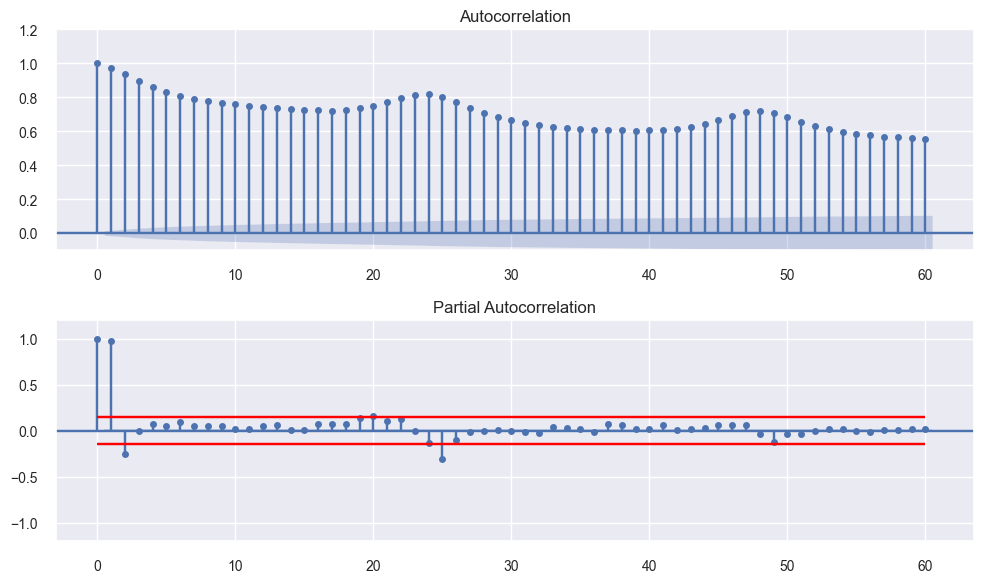

In [115]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(edf['price'] , lags=60, ax=ax1)
plot_pacf(edf['price'], lags=60, ax=ax2)
plt.tight_layout()
for ax in (ax1, ax2):
    ax.xaxis.set_minor_locator(MultipleLocator(2))
ax1.set_ylim(bottom=-0.1, top=1.2)
ax2.set_ylim(bottom=-1.2, top=1.2)
ax2.hlines(0.15, 0, 60, color='red')
ax2.hlines(-0.15, 0, 60, color='red')

In [116]:
## autocorrelation: what part of the time series is more correlated/anti-correlated to present time?
xydata = ax1.get_lines()[1].get_xydata()
for xx, yy in xydata:
    if abs(yy) > 0.90:
        print(f"{int(xx)}, {yy:0.3f}")

0, 1.000
1, 0.974
2, 0.936


In [117]:
## partial autocorrelation: what part of the time series is more correlated/anti-correlated to present time?
xydata = ax2.get_lines()[1].get_xydata()
for xx, yy in xydata:
    if abs(yy) > 0.15:
        print(f"{int(xx)}, {yy:0.3f}")

0, 1.000
1, 0.974
2, -0.255
20, 0.160
25, -0.312


Do the same thing for the load:

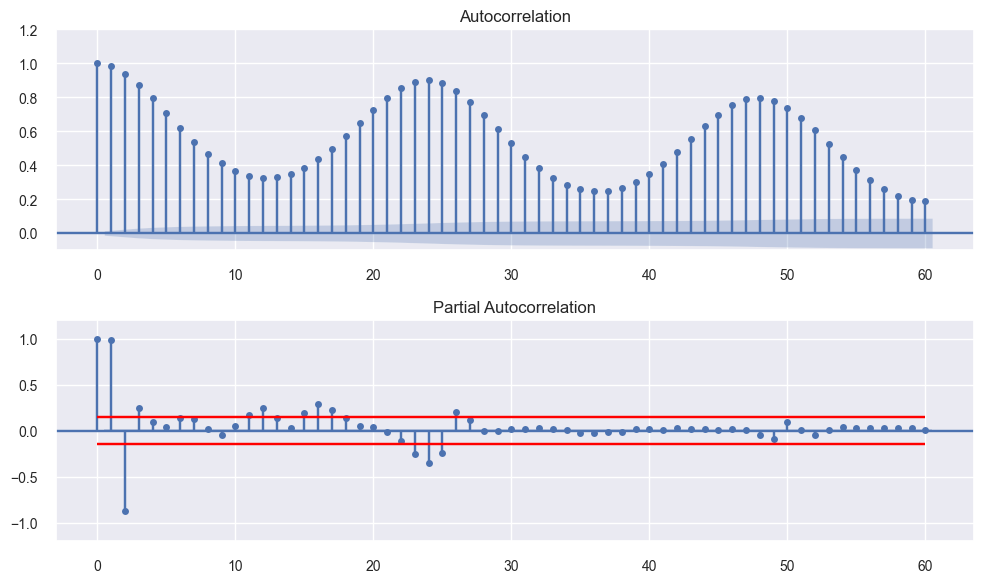

In [118]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(edf['actual_load'] , lags=60, ax=ax1)
plot_pacf(edf['actual_load'], lags=60, ax=ax2)
plt.tight_layout()
for ax in (ax1, ax2):
    ax.xaxis.set_minor_locator(MultipleLocator(2))
ax1.set_ylim(bottom=-0.1, top=1.2)
ax2.set_ylim(bottom=-1.2, top=1.2)
ax2.hlines(0.15, 0, 60, color='red')
ax2.hlines(-0.15, 0, 60, color='red')

In [119]:
## autocorrelation: what part of the time series is more correlated/anti-correlated to present time?
xydata = ax1.get_lines()[1].get_xydata()
for xx, yy in xydata:
    if abs(yy) > 0.90:
        print(f"{int(xx)}, {yy:0.3f}")

0, 1.000
1, 0.984
2, 0.939
24, 0.901


In [120]:
## partial autocorrelation: what part of the time series is more correlated/anti-correlated to present time?
xydata = ax2.get_lines()[1].get_xydata()
for xx, yy in xydata:
    if abs(yy) > 0.15:
        print(f"{int(xx)}, {yy:0.3f}")

0, 1.000
1, 0.984
2, -0.875
3, 0.247
11, 0.169
12, 0.248
15, 0.188
16, 0.287
17, 0.220
23, -0.259
24, -0.347
25, -0.247
26, 0.207


# Plotting

In [121]:
rolling_daily = edf['price'].rolling(24, center=True, min_periods=24).mean()
rolling_weekly = edf['price'].rolling(24*7, center=True, min_periods=24).mean()
rolling_monthly = edf['price'].rolling(24*7*4, center=True, min_periods=24).mean()

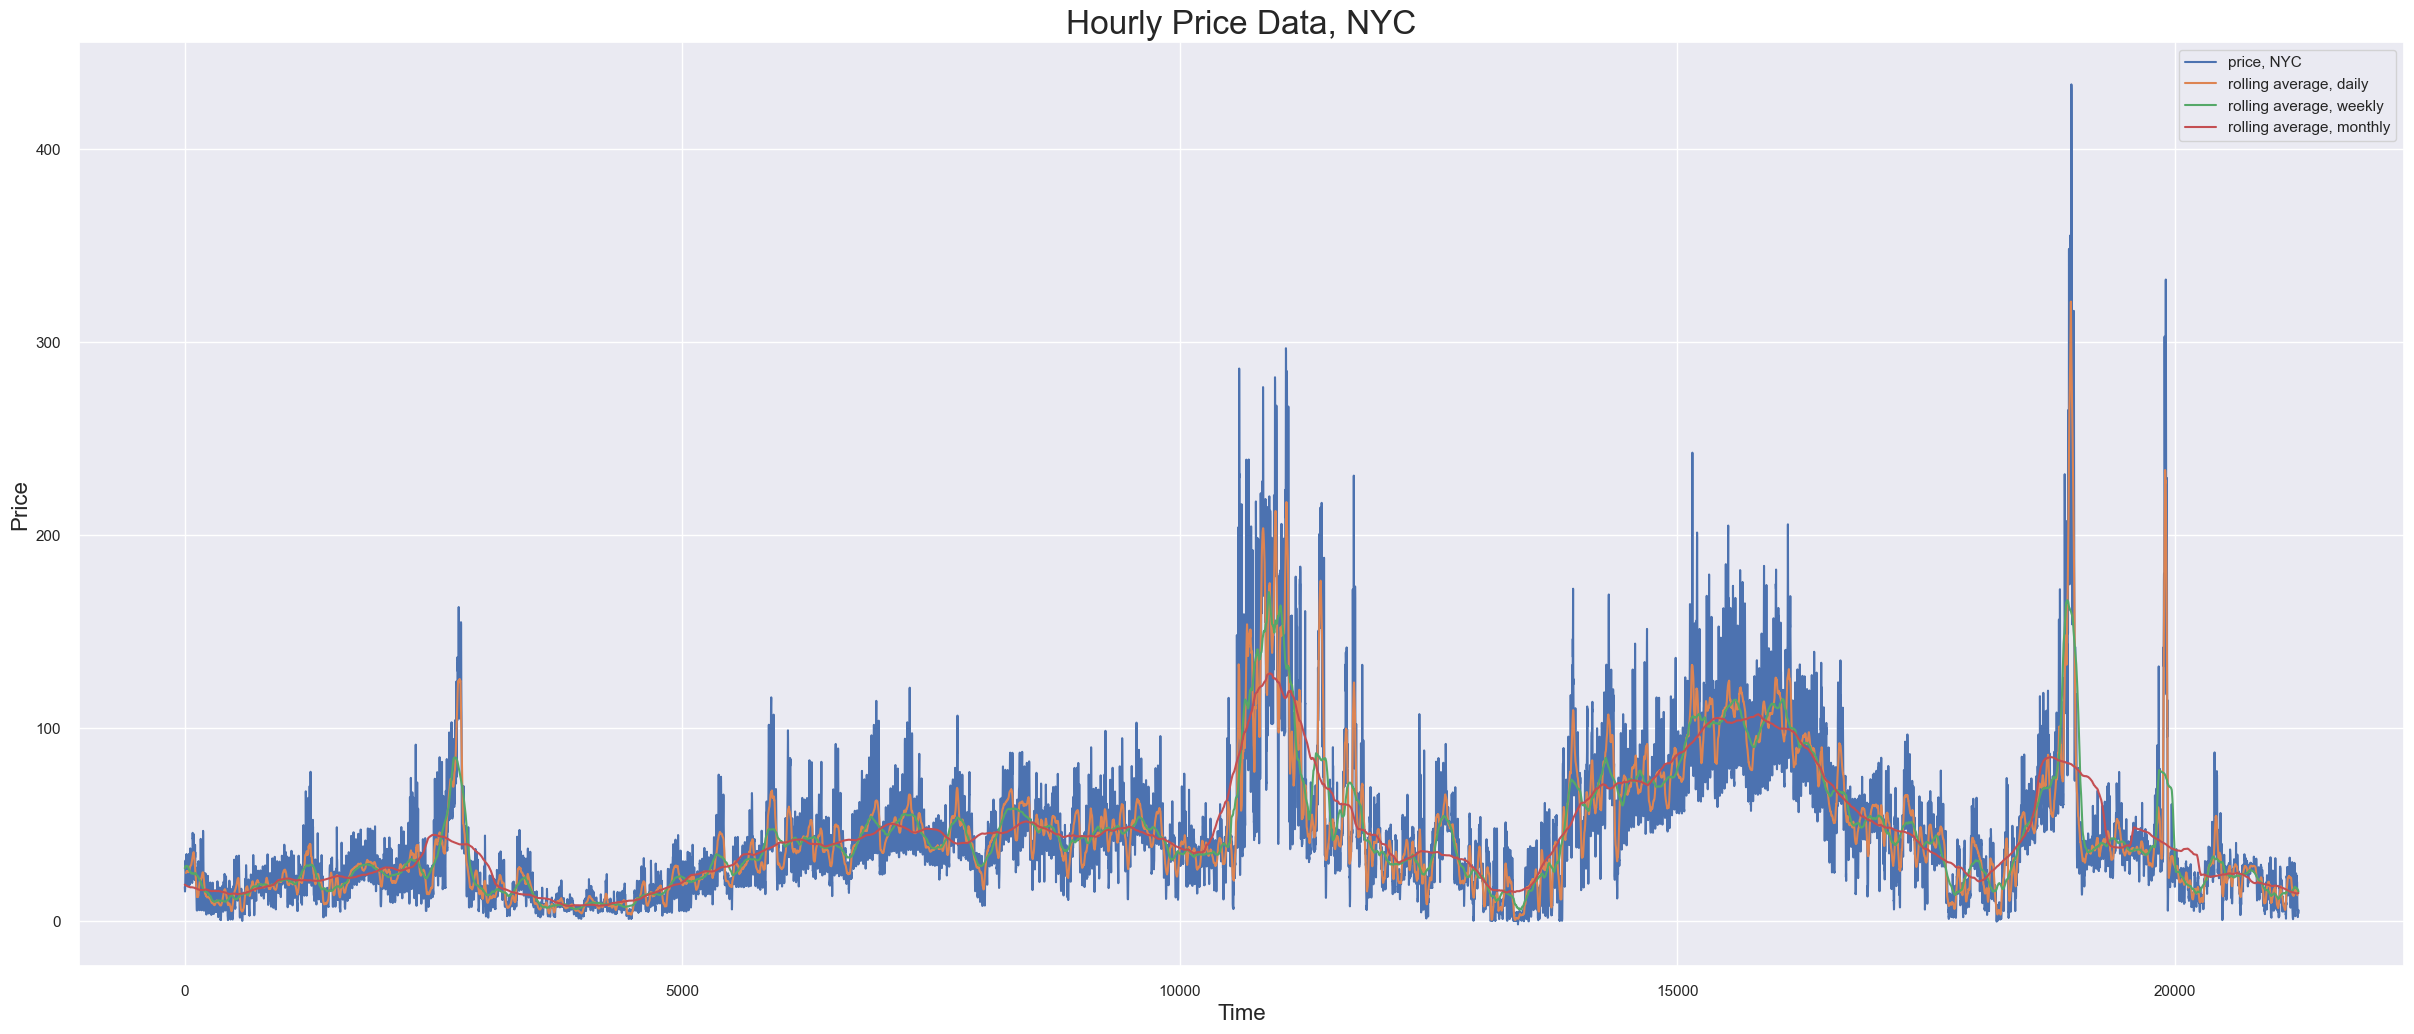

In [122]:
ax = plot_series(df=edf, column='price', label='price, NYC', 
                 ylabel='Price', title="Hourly Price Data, NYC", start=0, end=-1)
ax.plot(rolling_daily, label='rolling average, daily')
ax.plot(rolling_weekly, label='rolling average, weekly')
ax.plot(rolling_monthly, label='rolling average, monthly')
ax.legend(loc='best')

In [123]:
load_rolling_daily = edf['actual_load'].rolling(24, center=True, min_periods=24).mean()
load_rolling_weekly = edf['actual_load'].rolling(24*7, center=True, min_periods=24).mean()
load_rolling_monthly = edf['actual_load'].rolling(24*7*4, center=True, min_periods=24).mean()

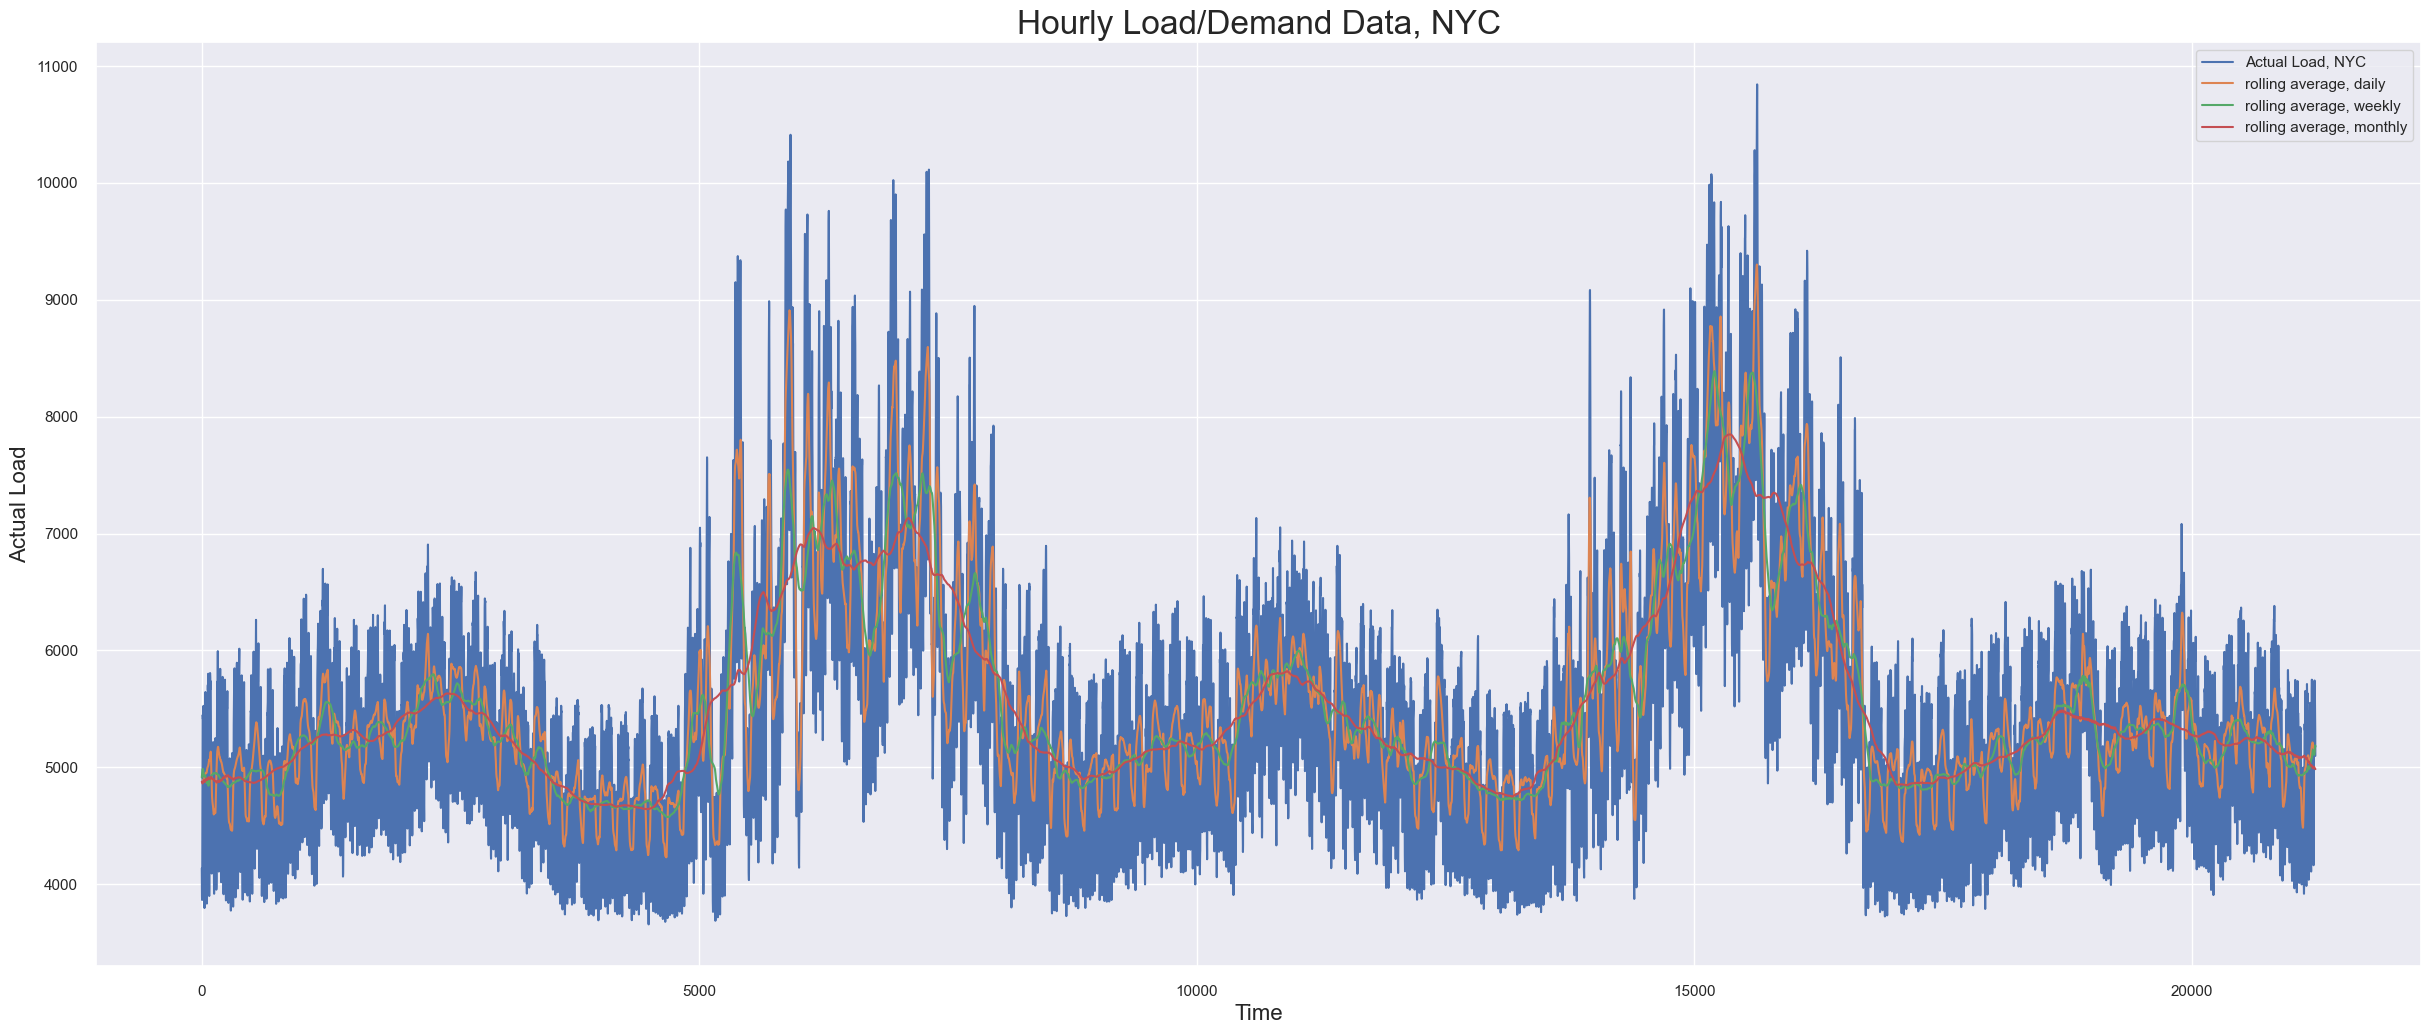

In [124]:
ax = plot_series(df=edf, column='actual_load', label='Actual Load, NYC', 
                 ylabel='Actual Load', title="Hourly Load/Demand Data, NYC", start=0, end=-1)
ax.plot(load_rolling_daily, label='rolling average, daily')
ax.plot(load_rolling_weekly, label='rolling average, weekly')
ax.plot(load_rolling_monthly, label='rolling average, monthly')
ax.legend(loc='best')

## Stationarity

In [125]:
y = edf['price']

In [126]:
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -5.734194
p-value: 0.000001
#Lags used: 46
Critical Value (1%): -3.430659
Critical Value (5%): -2.861676
Critical Value (10%): -2.566843


In [127]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 6.792018
p-value: 0.010000
#Lags used: 46
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


Both of the tests above show stationarity in the price data. Now, I'm also curious about the stationarity of the load data. This is not necessary for the current project (since we're not going to do load forecasting).

In [128]:
y = edf['actual_load']

In [129]:
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -7.346162
p-value: 0.000000
#Lags used: 46
Critical Value (1%): -3.430659
Critical Value (5%): -2.861676
Critical Value (10%): -2.566843


In [130]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 1.463902
p-value: 0.010000
#Lags used: 46
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


# Feature Selection/Creation

Base on the above, there are a few new features I should create and add to the dataframe. These are:
1. price data for $t-1,t-2,t-20,t-25$ hours (i.e. price an hour, 2 hours, 20 hours and 25 hours ago)
2. Souparna (via this [paper](https://www.sciencedirect.com/science/article/abs/pii/S0306261916304160)) also has _price in the same hour in the previous day and previous week_, as well as _load for the previous day and previous week_ (both at the same hour). There are also _average load_ and _average price_ in the previous day.
The features selected based on the correlations calculated above are _`actual_load`, `hour`, `business_hour`, `weekday`, `temp`, `dwpt`_.
Based on the above, I have to drop the first week of the data set, since I won't have enough data to fill out the features in the second point above. 

In [131]:
df.drop(['rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'weekly_T_anom',
       'monthly_T_anom', 'weekly_Prec_anom', 'monthly_Prec_anom',
       'weekly_Wind_anom', 'monthly_Wind_anom', 'weekly_Pressure_anom',
       'monthly_Pressure_anom', 'snowing', 'raining', 'hail', 'cloudy'], inplace=True, axis=1)

In [132]:
## add in the price data based on bullet point 1 in the above:
chosen_time_deltas_price = [1,2,20,25]
for index, row in df.iterrows():
    if index - 25 < 0:
        for j in chosen_time_deltas_price: 
            df.at[index,f'price(t-{j})']  = -1
    else: 
        for j in chosen_time_deltas_price: 
            df.at[index,f'price(t-{j})']  = df.iloc[index - j, 1]

In [133]:
df.head(3)

,time,price,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour,temp,dwpt,price(t-1),price(t-2),price(t-20),price(t-25)
0,2020-10-27 01:00:00+00:00,17.83,4137.0,2020-10-27,1.0,0.0,1.0,2.0,0.0,0.0,14.5,13.5,-1.0,-1.0,-1.0,-1.0
1,2020-10-27 02:00:00+00:00,16.44,3984.0,2020-10-27,2.0,0.0,1.0,2.0,0.0,0.0,14.4,13.6,-1.0,-1.0,-1.0,-1.0
2,2020-10-27 03:00:00+00:00,15.45,3895.0,2020-10-27,3.0,0.0,1.0,2.0,0.0,0.0,14.5,13.6,-1.0,-1.0,-1.0,-1.0


In [249]:
## now add in columns for previous day at same hour and previous week, same day same hour previous week
same_hr_prev_day = 24
same_hr_same_day_prev_week = 24 * 7
for index, row in df.iterrows():
    if index - same_hr_prev_day > 0:
        df.at[index,'price(d-1,t)']  = df.iloc[index - same_hr_prev_day, 1]
        df.at[index,'load(d-1,t)']  = df.iloc[index - same_hr_prev_day, 2]
    else:
        df.at[index,'price(d-1,t)']  = -1
        df.at[index,'load(d-1,t)']  = -1
    if index - same_hr_same_day_prev_week > 0:
        df.at[index,'price(d-7,t)']  = df.iloc[index - same_hr_same_day_prev_week, 1]
        df.at[index,'load(d-7,t)']  = df.iloc[index - same_hr_same_day_prev_week, 2]
    else: 
        df.at[index,'price(d-7,t)']  = -1
        df.at[index,'load(d-7,t)']  = -1

In [250]:
print(df.at[0, 'time'], df.at[23, 'time'])
average_price_ = df.iloc[0 : 24, 1].mean()
print(average_price_)

2020-10-27 01:00:00+00:00 2020-10-28 00:00:00+00:00
25.054166666666664


In [251]:
## average price and load from the previous day
average_price_ = df.iloc[0 : 24, 1].mean()
average_load_  = df.iloc[0 : 24, 2].mean()
for index, _ in df.iterrows():
    if index < 23:
        df.at[index, 'avg_price(d-1)'] = -1
        df.at[index, 'avg_load(d-1)'] = -1
        continue
    if index >= 23 and index <= 26:
        df.at[index, 'avg_price(d-1)'] = average_price_
        df.at[index, 'avg_load(d-1)'] = average_load_
        continue
    if (index >= 23) and df.at[index, 'hour'] < 1.0:
        average_price_ = df.iloc[index-24 : index, 1].mean()
        average_load_ = df.iloc[index-24 : index, 2].mean()
    df.at[index, 'avg_price(d-1)'] = average_price_
    df.at[index, 'avg_load(d-1)'] = average_load_

In [252]:
# with pd.option_context('display.max_rows', None):
#     #display(df)
#     print(df.iloc[0 : 78, [0,-2,-1]])

Have added a few colums and removed a few others. Redo the correlation studies to see if anything is actually correlated with the price?

In [253]:
edf = df[ (df.date >= datetime(2020,10,28)) & (df.date < datetime(2023,4,1))]

In [254]:
correlations_pearson = edf.corrwith(edf['price'], method='pearson', numeric_only=True, axis=0)
pearson_large_corr = correlations_pearson[correlations_pearson>correlation_minimum_cutoff]
print(abs(pearson_large_corr).sort_values(ascending=False).to_string())

price             1.000000
price(t-1)        0.974096
price(t-2)        0.935843
price(d-1,t)      0.818430
price(t-25)       0.800655
avg_price(d-1)    0.773548
price(t-20)       0.750605
price(d-7,t)      0.588958
actual_load       0.536837
load(d-1,t)       0.484902
avg_load(d-1)     0.441218
load(d-7,t)       0.438033
hour              0.147961
business_hour     0.137091


In [255]:
correlations_kendall = edf.corrwith(edf['price'], method='kendall', numeric_only=True, axis=0)
kendall_large_corr = correlations_kendall[correlations_kendall>correlation_minimum_cutoff]
print(abs(kendall_large_corr).sort_values(ascending=False).to_string())

price             1.000000
price(t-1)        0.886247
price(t-2)        0.810916
price(d-1,t)      0.705634
price(t-25)       0.686210
avg_price(d-1)    0.643630
price(t-20)       0.608004
price(d-7,t)      0.539880
actual_load       0.416711
load(d-1,t)       0.380932
load(d-7,t)       0.369481
avg_load(d-1)     0.363281
dwpt              0.143590
business_hour     0.137591
temp              0.128526
hour              0.123527


In [256]:
correlations_spearman = edf.corrwith(edf['price'], method='spearman', numeric_only=True, axis=0)
spearman_large_corr = correlations_spearman[correlations_spearman>correlation_minimum_cutoff]
print(abs(spearman_large_corr).sort_values(ascending=False).to_string())

price             1.000000
price(t-1)        0.978825
price(t-2)        0.946930
price(d-1,t)      0.872527
price(t-25)       0.858377
avg_price(d-1)    0.830979
price(t-20)       0.796213
price(d-7,t)      0.722851
actual_load       0.592074
load(d-1,t)       0.545650
load(d-7,t)       0.531198
avg_load(d-1)     0.527546
dwpt              0.211791
temp              0.187763
hour              0.180739
business_hour     0.168499
weekday           0.103605


Out of curiosity: what about including a rolling average of the past 24 hours?

In [223]:
window = 6

In [224]:
rolling_ = edf['price'].rolling(window, center=False, min_periods=window, closed='left').mean()
load_rolling_ = edf['actual_load'].rolling(window, center=False, min_periods=window, closed='left').mean()

In [225]:
print(f"rolling {window} hour average, pearson: {edf.price.corr(rolling_, method='pearson'):0.4f}")
print(f"rolling {window} hour average, kendall: {edf.price.corr(rolling_, method='kendall'):0.4f}")
print(f"rolling {window} hour average, spearman: {edf.price.corr(rolling_, method='spearman'):0.4f}")

rolling 6 hour average, pearson: 0.9132
rolling 6 hour average, kendall: 0.7562
rolling 6 hour average, spearman: 0.9182


In [226]:
print(f"rolling {window} hour average, pearson: {edf.price.corr(load_rolling_, method='pearson'):0.4f}")
print(f"rolling {window} hour average, kendall: {edf.price.corr(load_rolling_, method='kendall'):0.4f}")
print(f"rolling {window} hour average, spearman: {edf.price.corr(load_rolling_, method='spearman'):0.4f}")

rolling 6 hour average, pearson: 0.4612
rolling 6 hour average, kendall: 0.3309
rolling 6 hour average, spearman: 0.4809


In [230]:
edf['avg_price_rolling(t-6)'] = edf['price'].rolling(window, center=False, min_periods=window, closed='left').mean()

In [232]:
correlations_pearson = edf.corrwith(edf['price'], method='pearson', numeric_only=True, axis=0)
pearson_large_corr = correlations_pearson[correlations_pearson>correlation_minimum_cutoff]
print(abs(pearson_large_corr).sort_values(ascending=False).to_string())

price                     1.000000
price(t-1)                0.974096
price(t-2)                0.935843
avg_price_rolling(t-6)    0.913245
price(d-1,t)              0.818430
price(t-25)               0.800655
avg_price(d-1)            0.773548
price(t-20)               0.750605
price(d-7,t)              0.588958
actual_load               0.536837
avg_load(d-1)             0.441218
hour                      0.147961
business_hour             0.137091


a rolling average price is correlated with the current price but I already have $t-1$ and $t-2$ hours in the feature list. So I really don't think there's a need to include `avg_price_rolling(t-6)` in here as well.

How does our final data frame look now?

In [257]:
df.describe()

,price,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour,temp,...,price(t-1),price(t-2),price(t-20),price(t-25),"price(d-1,t)","price(d-7,t)",avg_price(d-1),avg_load(d-1),"load(d-1,t)","load(d-7,t)"
count,25640.000000,25640.000000,25640,25640.000000,25640.0,25640.000000,25640.000000,25640.0,25640.000000,25640.000000,...,25640.000000,25640.000000,25640.000000,25640.000000,25640.000000,25640.000000,25640.000000,25640.000000,25640.000000,25640.000000
mean,41.619206,5599.213814,2022-04-14 00:52:20.592823808,11.504524,0.0,0.714704,3.999766,0.0,0.297972,13.644134,...,41.594009,41.594159,41.595082,41.593537,41.593691,41.441333,41.456924,5593.547476,5594.741466,5567.260811
min,-1.590000,3657.000000,2020-10-27 00:00:00,0.000000,0.0,0.000000,1.000000,0.0,0.000000,-15.200000,...,-1.590000,-1.590000,-1.590000,-1.590000,-1.590000,-1.590000,-1.000000,-1.000000,-1.000000,-1.000000
25%,20.370000,4773.750000,2021-07-21 00:00:00,6.000000,0.0,0.000000,2.000000,0.0,0.000000,5.900000,...,20.340000,20.340000,20.340000,20.330000,20.330000,20.080000,21.656250,4960.666667,4771.750000,4760.000000
50%,32.510000,5459.000000,2022-04-14 00:00:00,12.000000,0.0,1.000000,4.000000,0.0,0.000000,13.800000,...,32.510000,32.510000,32.510000,32.510000,32.510000,32.475000,33.565000,5320.083333,5459.000000,5457.000000
75%,50.870000,6128.000000,2023-01-06 00:00:00,18.000000,0.0,1.000000,6.000000,0.0,1.000000,21.900000,...,50.870000,50.870000,50.870000,50.870000,50.870000,50.870000,50.665417,5944.166667,6128.000000,6128.000000
max,433.460000,10842.000000,2023-10-01 00:00:00,23.000000,0.0,1.000000,7.000000,0.0,1.000000,35.600000,...,433.460000,433.460000,433.460000,433.460000,433.460000,433.460000,320.975833,9291.541667,10842.000000,10842.000000
std,35.359242,1158.883268,NaN,6.918625,0.0,0.451564,1.997776,0.0,0.457376,9.618093,...,35.379986,35.379899,35.379537,35.380450,35.380355,35.502769,31.871568,949.299359,1171.487360,1241.945492


In [259]:
df.head(48)

,time,price,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour,...,price(t-1),price(t-2),price(t-20),price(t-25),"price(d-1,t)","price(d-7,t)",avg_price(d-1),avg_load(d-1),"load(d-1,t)","load(d-7,t)"
0,2020-10-27 01:00:00+00:00,17.83,4137.0,2020-10-27,1.0,0.0,1.0,2.0,0.0,0.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0
1,2020-10-27 02:00:00+00:00,16.44,3984.0,2020-10-27,2.0,0.0,1.0,2.0,0.0,0.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0
2,2020-10-27 03:00:00+00:00,15.45,3895.0,2020-10-27,3.0,0.0,1.0,2.0,0.0,0.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0
3,2020-10-27 04:00:00+00:00,16.51,3866.0,2020-10-27,4.0,0.0,1.0,2.0,0.0,0.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0
4,2020-10-27 05:00:00+00:00,17.04,3909.0,2020-10-27,5.0,0.0,1.0,2.0,0.0,0.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0
5,2020-10-27 06:00:00+00:00,24.41,4121.0,2020-10-27,6.0,0.0,1.0,2.0,0.0,0.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0
6,2020-10-27 07:00:00+00:00,30.03,4547.0,2020-10-27,7.0,0.0,1.0,2.0,0.0,0.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0
7,2020-10-27 08:00:00+00:00,31.50,4976.0,2020-10-27,8.0,0.0,1.0,2.0,0.0,1.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0
8,2020-10-27 09:00:00+00:00,30.60,5271.0,2020-10-27,9.0,0.0,1.0,2.0,0.0,1.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0
9,2020-10-27 10:00:00+00:00,29.69,5448.0,2020-10-27,10.0,0.0,1.0,2.0,0.0,1.0,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.000000,-1.000000,-1.0,-1.0


In [260]:
df.set_index('time')

,price,actual_load,date,hour,minute,weekday,day_of_week,holiday,business_hour,temp,...,price(t-1),price(t-2),price(t-20),price(t-25),"price(d-1,t)","price(d-7,t)",avg_price(d-1),avg_load(d-1),"load(d-1,t)","load(d-7,t)"
time,,,,,,,,,,,,,,,,,,,,,
2020-10-27 01:00:00+00:00,17.83,4137.0,2020-10-27,1.0,0.0,1.0,2.0,0.0,0.0,14.5,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.000000,-1.000,-1.0,-1.0
2020-10-27 02:00:00+00:00,16.44,3984.0,2020-10-27,2.0,0.0,1.0,2.0,0.0,0.0,14.4,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.000000,-1.000,-1.0,-1.0
2020-10-27 03:00:00+00:00,15.45,3895.0,2020-10-27,3.0,0.0,1.0,2.0,0.0,0.0,14.5,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.000000,-1.000,-1.0,-1.0
2020-10-27 04:00:00+00:00,16.51,3866.0,2020-10-27,4.0,0.0,1.0,2.0,0.0,0.0,14.3,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.000000,-1.000,-1.0,-1.0
2020-10-27 05:00:00+00:00,17.04,3909.0,2020-10-27,5.0,0.0,1.0,2.0,0.0,0.0,14.3,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.000000,-1.000,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01 01:00:00+00:00,23.76,4266.0,2023-10-01,1.0,0.0,0.0,7.0,0.0,0.0,17.5,...,24.96,23.52,21.79,25.21,23.20,14.77,25.597917,4593.125,4217.0,4268.0
2023-10-01 02:00:00+00:00,20.98,4075.0,2023-10-01,2.0,0.0,0.0,7.0,0.0,0.0,17.6,...,23.76,24.96,25.18,23.20,21.24,13.84,25.597917,4593.125,4032.0,4090.0
2023-10-01 03:00:00+00:00,20.76,3974.0,2023-10-01,3.0,0.0,0.0,7.0,0.0,0.0,16.8,...,20.98,23.76,24.81,21.24,20.41,11.95,25.597917,4593.125,3894.0,3956.0


In [261]:
df.to_csv("../rouz_final_DF_v1.csv")